<h1>Prompt Image Matching Process</h1>

In [172]:
import pandas as pd

tagged_sample_df = pd.read_csv('sample_dataset_tagged_2025_02_13_23_28_26.csv')
tagged_sample_df.head()

,file_name,tagging_vitgpt2
0,4afccb317564489cab6f7d70985fdba0.jpg,a tree with a bunch of white flowers in it
1,dd696f3d76e84050a5050d9c80a0ec16.jpg,"a sign that says ""no parking"" on a pole"
2,e25114803e2e4b69bf1c0ec3eef96142.jpg,a woman in a blue shirt and a blue tie
3,ce77214244834cf38e9be5edec8c3eea.jpg,a woman is putting on makeup on a woman
4,e38172f9991448fe84ff8b09a4fbf51a.jpg,a young boy sitting on the grass eating someth...


<h2>Labelled Images</h2>

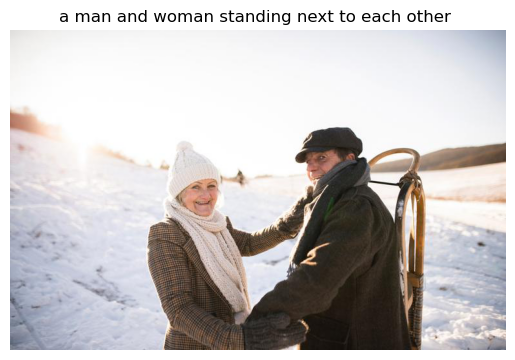

In [173]:
id = 28
image_name = tagged_sample_df.iloc[id].file_name
image_tag = tagged_sample_df.iloc[id].tagging_vitgpt2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_filename = '../sample_images/'+image_name
#image_filename = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
img = mpimg.imread(image_filename)
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.title(image_tag)
plt.show()

<h2>Text Matching Algorithm - TFIDF</h2>

In [174]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer

n_feats = 200
tfidf = TfidfVectorizer(stop_words='english') #Term Frequency Matrix  max_features=n_feats
X = tfidf.fit_transform(tagged_sample_df['tagging_vitgpt2']).toarray()
X.shape #get feature matrix size

(500, 449)

In [218]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np
#image_recommender
def image_recommender(tagged_sample_df_,tagger,tf_idf,X_matrix,text,thr_=0.35,top_n=10):
    X_text = tf_idf.transform([text])
    cosine_sim_matrix = cosine_similarity(X_text,X_matrix)
    cosine_sim_matrix = cosine_sim_matrix[0]
    sort_ids = np.argsort(cosine_sim_matrix)#sort 
    sort_ids = sort_ids[::-1]#descendingly
    features_df_rec = tagged_sample_df_.loc[sort_ids,['file_name',tagger]]
    features_df_rec['sim'] = cosine_sim_matrix[sort_ids]
    output_df_ = features_df_rec[features_df_rec['sim'] > thr_]
    output_df = output_df_.iloc[0:top_n,:]
    return output_df 

In [219]:
text = 'people are happy'
tagger = 'tagging_vitgpt2'
top_k = 10

import time

tic = time.time()
output_df = image_recommender(tagged_sample_df,tagger,tfidf,
                               X,text,thr_=0.00,top_n=top_k)
toc = time.time()
# Print elapsed time
print(f"Execution Time: {toc - tic:.4f} seconds")

Execution Time: 0.0146 seconds


In [220]:
output_df

,file_name,tagging_vitgpt2,sim
288,5a09239c52884a0b9093941c331c05e6.jpg,people sitting at a table,0.806763
101,569e7907dc1747ec9cf8ca451d2b44d2.jpg,a crowd of people standing around a group of p...,0.779447
243,4c00e18f23b84451bbd18911f88aab12.jpg,people are gathered around a picnic table,0.514979


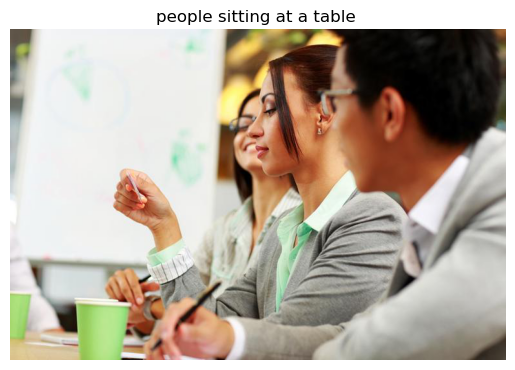

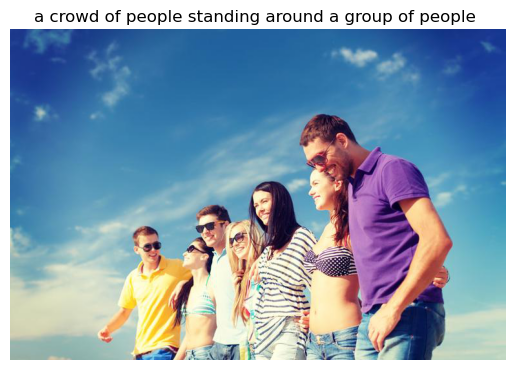

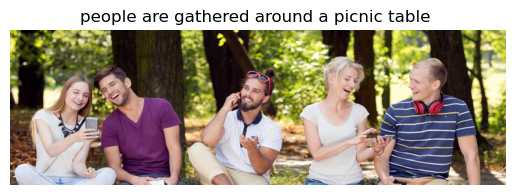

In [221]:
for i in range(len(output_df)):
    image_name = output_df.iloc[i].file_name
    image_tag =  output_df.iloc[i].tagging_vitgpt2
    image_filename = '../sample_images/'+image_name
    #image_filename = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    img = mpimg.imread(image_filename)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_tag)
    plt.show()

In [222]:
#pip install dill


<h2>Text Matching Algorithm - SBERT</h2>

In [223]:
#pip install sentence_transformers 

In [224]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")  # Optimized for sentence similarity

# Example paragraphs
#paragraph1 = "Artificial Intelligence is transforming the world by automating tasks and making predictions."
#paragraph2 = "Machine learning is revolutionizing industries by enabling automation and predictive analytics."

paragraph1 = "a man and a woman"
paragraph2 = "a male and a female"
# Generate embeddings
embedding1 = model.encode(paragraph1, convert_to_tensor=True)
embedding2 = model.encode(paragraph2, convert_to_tensor=True)

# Compute Cosine Similarity
similarity_score = util.pytorch_cos_sim(embedding1, embedding2).item()

print(f"Similarity Score: {similarity_score:.4f}")  # Output: 0.85 (Higher means more similar)

Similarity Score: 0.8546


In [225]:
model = SentenceTransformer("all-MiniLM-L6-v2")  # Optimized for sentence similarity
sbert_corpus_embeddings = []
ns = len(tagged_sample_df)
for i in range(ns):
    paragraph2 = tagged_sample_df.at[i,tagger]
    embedding2 = model.encode(paragraph2, convert_to_tensor=True)
    sbert_corpus_embeddings.append(embedding2)

In [226]:
def sbert_image_recommender(tagged_sample_df_,tagger,text,thr_=0.35,top_n=10):
    embedding1 = model.encode(text, convert_to_tensor=True)
    ns = len(tagged_sample_df_)
    bert_score_list = []
    for i in range(ns):
        embedding2 = sbert_corpus_embeddings[i]
        similarity_score = util.pytorch_cos_sim(embedding1, embedding2).item()
        bert_score_list.append(similarity_score)    
    output_df_ = tagged_sample_df_.copy()
    output_df_['sbert_sim'] = bert_score_list
    output_df_ = output_df_.sort_values(by='sbert_sim', ascending=False)
    c_output_df = output_df_.iloc[0:top_n,:]
    return c_output_df

In [227]:
import time

tic = time.time()
sbert_output_df = sbert_image_recommender(tagged_sample_df,tagger,text,thr_=0.35,top_n=10)
toc = time.time()
# Print elapsed time
print(f"Execution Time: {toc - tic:.4f} seconds")

Execution Time: 0.5080 seconds


In [228]:
sbert_output_df.head()

,file_name,tagging_vitgpt2,sbert_sim
101,569e7907dc1747ec9cf8ca451d2b44d2.jpg,a crowd of people standing around a group of p...,0.436321
288,5a09239c52884a0b9093941c331c05e6.jpg,people sitting at a table,0.404216
343,fe306411f378499dbcfeb4df9d1fad38.jpg,a man is sitting down and smiling,0.395367
243,4c00e18f23b84451bbd18911f88aab12.jpg,people are gathered around a picnic table,0.381060
367,f3f10771422e4bd9aac05a321715caa3.jpg,a woman is smiling while holding a white object,0.378396


In [229]:
print('Number of records:',len(sbert_output_df))

Number of records: 10


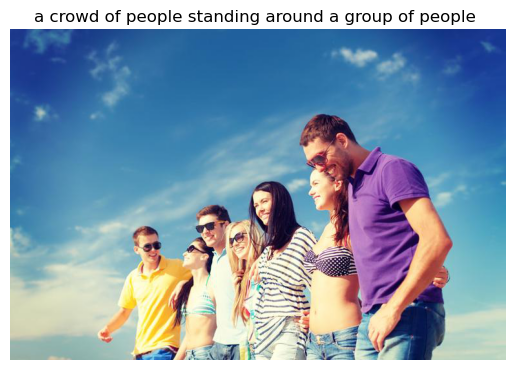

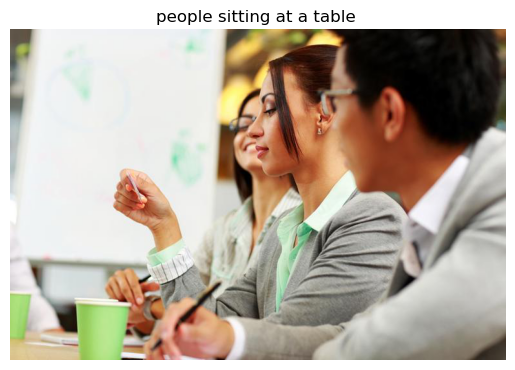

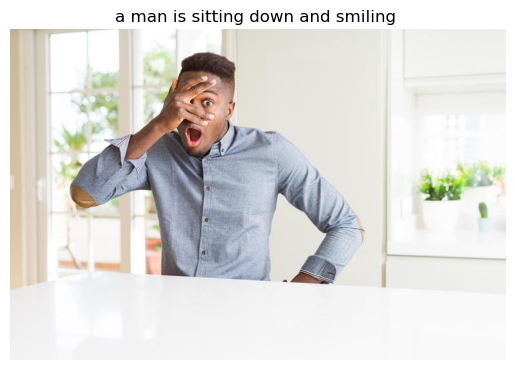

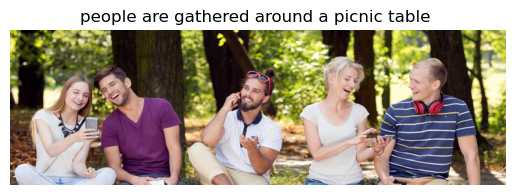

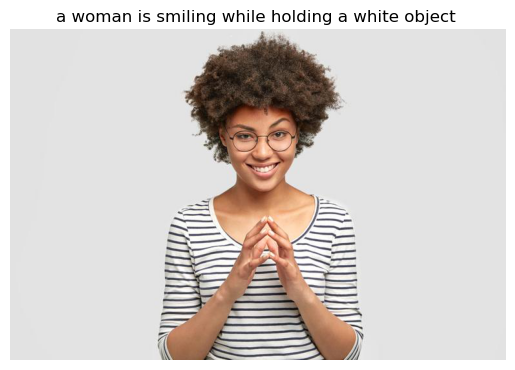

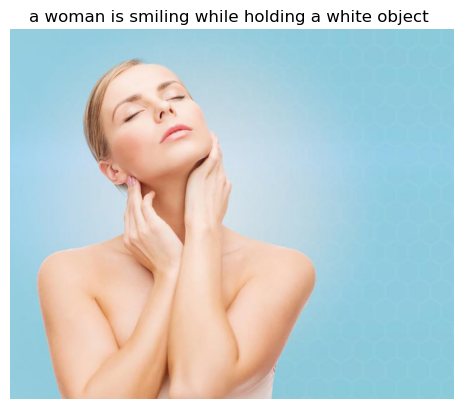

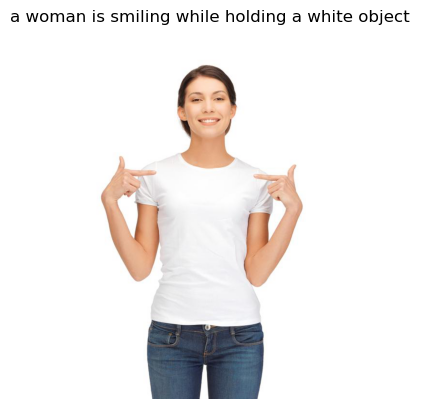

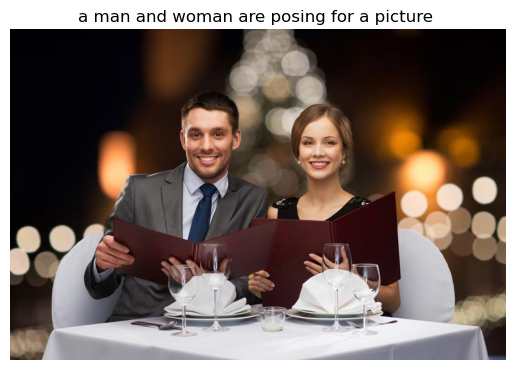

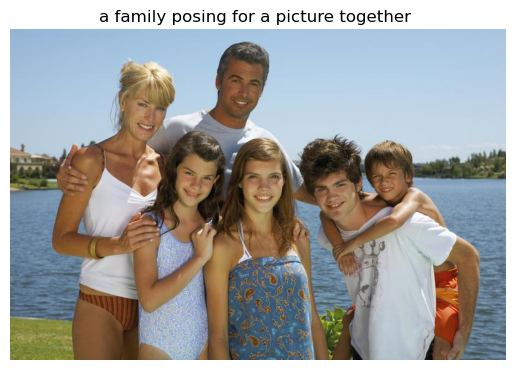

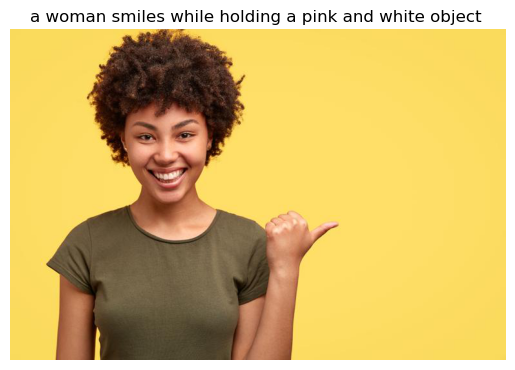

In [230]:
for i in range(len(sbert_output_df)):
    image_name = sbert_output_df.iloc[i].file_name
    image_tag =  sbert_output_df.iloc[i].tagging_vitgpt2
    image_filename = '../sample_images/'+image_name
    #image_filename = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    img = mpimg.imread(image_filename)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_tag)
    plt.show()

<h2>Text Matching Algorithm - Word2Vec</h2>

In [1]:
import gensim.downloader
# Show all available models in gensim-data
gensim_pretrains = list(gensim.downloader.info()['models'].keys())

N = len(gensim_pretrains)
for i in range(N):
    pretrain_model_name = gensim_pretrains[i]
    print("[",i+1,"] ", pretrain_model_name)

[ 1 ]  fasttext-wiki-news-subwords-300
[ 2 ]  conceptnet-numberbatch-17-06-300
[ 3 ]  word2vec-ruscorpora-300
[ 4 ]  word2vec-google-news-300
[ 5 ]  glove-wiki-gigaword-50
[ 6 ]  glove-wiki-gigaword-100
[ 7 ]  glove-wiki-gigaword-200
[ 8 ]  glove-wiki-gigaword-300
[ 9 ]  glove-twitter-25
[ 10 ]  glove-twitter-50
[ 11 ]  glove-twitter-100
[ 12 ]  glove-twitter-200
[ 13 ]  __testing_word2vec-matrix-synopsis


In [11]:
model_i = 4 #ruscorpora(deja), glove-twitter-25 (deja), word2vec-google-news-300 (deja)
pretrain_model_name = gensim_pretrains[model_i-1]
word2vec_model = gensim.downloader.load(pretrain_model_name)


In [3]:
text_in = 'technology'
print(f'Pretrain model: {pretrain_model_name} -> Word: {text_in}')
list_sim = word2vec_model.most_similar(text_in)

for sim in list_sim:
    print(sim)

Pretrain model: word2vec-google-news-300 -> Word: technology
('technologies', 0.8332264423370361)
('innovations', 0.6230790615081787)
('technological_innovations', 0.6102178692817688)
('technol', 0.6047338247299194)
('technological_advancement', 0.6036396622657776)
('cutting_edge', 0.603604793548584)
('technological_innovation', 0.6024577617645264)
('technological_advancements', 0.5967105627059937)
('innovation', 0.5921422839164734)
('Technology', 0.5899151563644409)


In [9]:

text_vec = word2vec_model[text_in]
print('Vector representation of %s :(%d x 1)'%(text_in,text_vec.shape[0]))
print(text_vec)

Vector representation of technology :(300 x 1)
[ 0.04345703  0.00183105  0.18457031  0.00671387 -0.11376953  0.00479126
  0.07128906 -0.09228516 -0.01531982 -0.09521484 -0.08642578 -0.08544922
 -0.03125    -0.13476562 -0.19921875 -0.05224609 -0.04956055 -0.03271484
 -0.08496094 -0.06933594 -0.11328125 -0.01916504 -0.0625      0.19042969
 -0.03491211  0.10058594 -0.01916504  0.04833984  0.05737305 -0.27539062
 -0.00204468 -0.08837891 -0.12451172 -0.08398438  0.13085938 -0.14746094
 -0.00756836 -0.11132812  0.203125   -0.00817871 -0.12695312  0.22851562
  0.03588867 -0.00671387  0.05444336 -0.06054688 -0.20214844 -0.09912109
  0.01269531  0.15332031  0.0222168   0.01342773 -0.12890625 -0.23632812
 -0.05126953  0.203125    0.04492188 -0.12695312  0.36914062 -0.05810547
 -0.03588867 -0.09716797 -0.24707031  0.04589844 -0.296875    0.11132812
 -0.14550781  0.22558594 -0.02770996  0.03979492 -0.17871094 -0.05932617
  0.08544922  0.10009766  0.06103516  0.00473022  0.10546875  0.18847656
 -0.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity 

word1 = 'car'
word2 = 'truck'

word2vec_1 = word2vec_model[word1].reshape(1,-1)
word2vec_2 = word2vec_model[word2].reshape(1,-1)

w2v_cosine_similarity = cosine_similarity(word2vec_1,word2vec_2)
print(f'{word1} vs {word2} = {w2v_cosine_similarity[0][0]}')

car vs truck = 0.6735790371894836


<h2>Storing the solution</h2>

In [231]:
import dill as pickle

with open('image_recommender_model_vitgpt2_tidf_files.pkl', 'wb') as f:
    pickle.dump(image_recommender, f)
    pickle.dump(tagged_sample_df, f)
    pickle.dump(tfidf, f)
    pickle.dump(X, f)

In [232]:
with open('image_recommender_model_vitgpt2_tidf_files.pkl', 'rb') as f:
    system_image_recommender = pickle.load(f)
    tagged_sample_df = pickle.load(f)
    tfidf = pickle.load(f)
    X_matrix = pickle.load(f)
    
text = 'man'
tagger = 'tagging_vitgpt2'
output_df = system_image_recommender(tagged_sample_df,tagger,tfidf,
                              X_matrix,text,thr_=0.0,top_n=10)
output_df

,file_name,tagging_vitgpt2,sim
349,795e7cb706214f988f1f813d3f09b13d.jpg,a man and woman standing next to each other,0.539154
446,f6de86bf5cbe45c997f2d18308f57742.jpg,a man and woman standing next to each other,0.539154
137,5d6f79b08bd5436bb6a4e71ba37426cb.jpg,a man and woman standing next to each other,0.539154
68,964b7906421443cb9b5b6e14c0996fa5.jpg,a man and woman standing next to each other,0.539154
28,b187535ef69846f9be8b70483003d183.jpg,a man and woman standing next to each other,0.539154
280,5623dc1189b04c09a5e066f237a3dff1.jpg,a man in a blue shirt and a man in a white shirt,0.504282
183,83b5355ed7cc4f35afad223bef41a41e.jpg,a man and woman are sitting at a table,0.501110
35,ccb476d7699642c9a72f06ee1e0118b9.jpg,a woman and a man sitting at a table,0.501110
157,246cf42387db4207961a7bb07b89089b.jpg,a woman and a man are sitting at a table,0.501110
444,029baa4502914e898d79754a15401e0a.jpg,a woman sitting on a couch with a man,0.434393
